# Searching for Survivors

+ This is the project _Titanic: Machine Learning from Disaster_** @[kaggle](https://www.kaggle.com/c/titanic).


### Objective

Titanic was once the most fabulous and luxurious passenger liner in the world. On Apr 15th 1912, Titanic sank in the Atlantic Ocean after colliding with an iceberg. 1,502 out of 2224 passengers and crew died in this tragedy. Probably you heard some touching stories and movies about it before. This time, let us make some predictions, searching for potential survivors!

### Data Description

To access to the data, click the [link](https://www.kaggle.com/c/titanic/data)!

Variable|Definition|Note
---|---|---
Survived|Survival|0 = No, 1 = Yes
Pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd
Sex|Sex| 
Age|Age in years|
SibSp|# of siblings / spouses aboard the Titanic|
Parch|# of parents / children aboard the Titanic|
Ticket|Ticket number|
Fare|Passenger fare|
Cabin|Cabin number|
Embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton

### First Impression
From the table below, there are some missing values among data. We need to take care of it. And, possibly, there are some meaningful information in passengers' names and tickets.  

In [1]:
import numpy as np
import pandas as pd
import ticart as ti #Decision Tree package with Post-Pruning
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pd.options.mode.chained_assignment = None 

In [2]:
#Read Data
df = pd.read_csv('train.csv')
df_pred = pd.read_csv('test.csv')
df.drop('PassengerId',axis=1,inplace=True)
df.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
print 'Total number of passengers:' , df.shape[0]
print 'Total number of surviors  :', df['Survived'].sum()
print 'For each variable, non-Nan values:'
print  df.count(axis=0)

Total number of passengers: 891
Total number of surviors  : 342
For each variable, non-Nan values:
Survived    891
Pclass      891
Name        891
Sex         891
Age         714
SibSp       891
Parch       891
Ticket      891
Fare        891
Cabin       204
Embarked    889
dtype: int64


### Okay! Let's start.
First, let's deal with missing value. How to impute missing value would be a big issue! 
+ If the missing value only takes up around 5%, it would be fine to replace them with median or mode (depends on whether it is continous or categorical). 
+ If the missing value are missing at random, we could use Multiple Imputation, KNN or simply median/mode for imputation. 
+ If the value is missed with a pattern, 'Missing' could be some important indicators for prediction.

In [4]:
#Split data before imputation and pre-processing
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.3, random_state=7)

In [5]:
#Explore relation between missing value with target label
def plt_na(data, feature, target):
    plt.figure()
    plt.hist(data.loc[pd.isnull(data[feature]),target],bins = 2,normed = True, alpha = 0.5, color = 'r',label = 'NaN')
    plt.hist(data.loc[~pd.isnull(data[feature]),target],bins = 2,normed = True, alpha = 0.5, color = 'b', label = 'non-Nan')
    plt.title(feature + ' NaN or not vs ' + target +' or not')
    plt.legend()
    plt.xlabel(target)
    plt.xticks([0.25,0.75],['No','Yes'])
    plt.ylim([0,2.0])
    plt.show()

There are respectively 19.87% and 77.10% of values lost in Age and Cabin. From the distribution below, we could find missing among Cabin itself is important in describing survival, while no significant pattern between missing Age and survival.

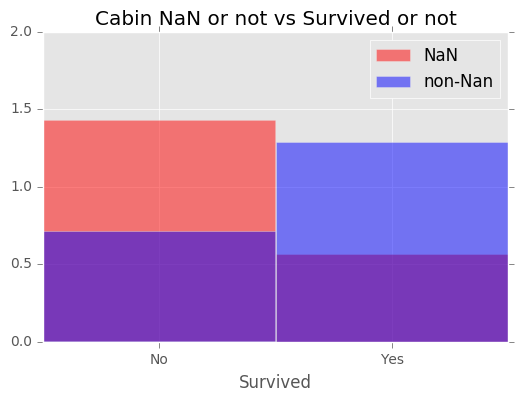

In [6]:
#Check what's special for cabin feature
plt_na(df_train, 'Cabin', 'Survived')

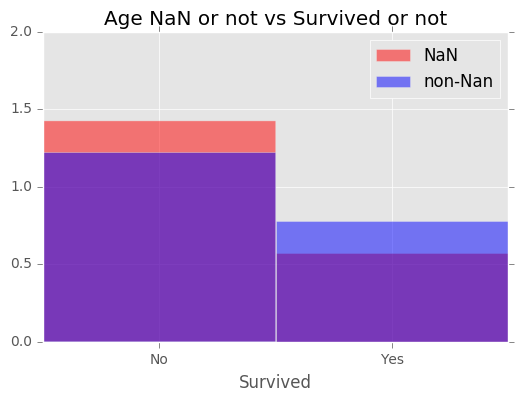

In [7]:
#Check what's special for age feature
plt_na(df_train, 'Age', 'Survived')

Let's do more statistically! Use Chi-Square Independence test to check if 'Missing' independent to 'Survival'. 

Yes! 'Missing' in 'Cabin' is significantly dependent on 'Survival', while 'Missing' in 'Age' is not. So keep missing information in Cabin and replace missing in Age with median.

In [8]:
from scipy.stats import chisquare

In [9]:
print "Survival Status | NA in Cabin | Non-NA in Cabin | Total"
print "Survived         ", df_train['Survived'][pd.isnull(df_train['Cabin'])].sum(),"         " ,df_train['Survived'][~pd.isnull(df_train['Cabin'])].sum(),"              " ,df_train['Survived'].sum()
print "Non-Survived     ", df_train['Survived'][((pd.isnull(df_train['Cabin'])) & (df_train['Survived'] == 0))].count(),"         ", df_train['Survived'][((~pd.isnull(df_train['Cabin'])) & (df_train['Survived'] == 0))].count(),"              " , df_train['Survived'][df_train['Survived']==0].count()
print "Total            ", df_train['Survived'][pd.isnull(df_train['Cabin'])].count(),"         " , df_train['Survived'][~pd.isnull(df_train['Cabin'])].count(),"             " , df_train['Survived'].count()

Survival Status | NA in Cabin | Non-NA in Cabin | Total
Survived          136           94                230
Non-Survived      341           52                393
Total             477           146               623


In [10]:
stats_cabin = chisquare([136,94,341,52],f_exp = [477*230/623,146*230/623,477*393/623,146*393/623])
print 'Chi-Square Test for Cabin: Statistic = ',stats_cabin[0],', P-value = ',stats_cabin[1]

Chi-Square Test for Cabin: Statistic =  63.8025279041 , P-value =  9.04627329003e-14


In [11]:
print "Survival Status | NA in Age | Non-NA in Age | Total"
print "Survived         ", df_train['Survived'][pd.isnull(df_train['Age'])].sum(),"        " ,df_train['Survived'][~pd.isnull(df_train['Age'])].sum(),"           " ,df_train['Survived'].sum()
print "Non-Survived     ", df_train['Survived'][((pd.isnull(df_train['Age'])) & (df_train['Survived'] == 0))].count(),"        ", df_train['Survived'][((~pd.isnull(df_train['Age'])) & (df_train['Survived'] == 0))].count(),"           " , df_train['Survived'][df_train['Survived']==0].count()
print "Total            ", df_train['Survived'][pd.isnull(df_train['Age'])].count(),"       " , df_train['Survived'][~pd.isnull(df_train['Age'])].count(),"           " , df_train['Survived'].count()

Survival Status | NA in Age | Non-NA in Age | Total
Survived          35          195             230
Non-Survived      87          306             393
Total             122         501             623


In [12]:
stats_age = chisquare([35,195,87,306],f_exp = [122*230/623,501*230/623,122*393/623,501*393/623])
print 'Chi-Square Test for Age: Statistic = ',stats_age[0],', P-value = ',stats_age[1]

Chi-Square Test for Age: Statistic =  4.78839187723 , P-value =  0.187964286038


In [13]:
#Replace NA in Cabin with 1 and non-NA with 0
df_train.loc[~pd.isnull(df_train['Cabin']),['Cabin']] = 0
df_test.loc[~pd.isnull(df_test['Cabin']),['Cabin']] = 0
df_train.loc[pd.isnull(df_train['Cabin']),['Cabin']] = 1
df_test.loc[pd.isnull(df_test['Cabin']),['Cabin']] = 1
df_pred.loc[~pd.isnull(df_pred['Cabin']),['Cabin']] = 0
df_pred.loc[pd.isnull(df_pred['Cabin']),['Cabin']] = 1

In [14]:
#Impute missing value with mode
df_train.loc[pd.isnull(df_train['Age']),['Age']] = df_train['Age'].mode()[0]
df_test.loc[pd.isnull(df_test['Age']),['Age']] = df_train['Age'].mode()[0]
df_pred.loc[pd.isnull(df_pred['Age']),['Age']] = df_train['Age'].mode()[0]

In [15]:
#Replace NA entries in Embarked with Mode and convert Embarked into numbers(C:0, S:1, Q:2)
df_train.loc[pd.isnull(df_train['Embarked']),['Embarked']] = df_train['Embarked'].mode()[0]
df_test.loc[pd.isnull(df_test['Embarked']),['Embarked']] = df_train['Embarked'].mode()[0]
df_pred.loc[pd.isnull(df_pred['Embarked']),['Embarked']] = df_train['Embarked'].mode()[0]
df_train.loc[:,'Embarked'] = df_train.Embarked.map({'C':0,'S':1,'Q':2})
df_test.loc[:,'Embarked'] = df_test.Embarked.map({'C':0,'S':1,'Q':2})
df_pred.loc[:,'Embarked'] = df_pred.Embarked.map({'C':0,'S':1,'Q':2})

Secondly, let's check information among string values!

To be honest, string in Ticket are too complicated to disect. And there is no significant difference between pure number tickets with alphabetic tickes. Drop it!

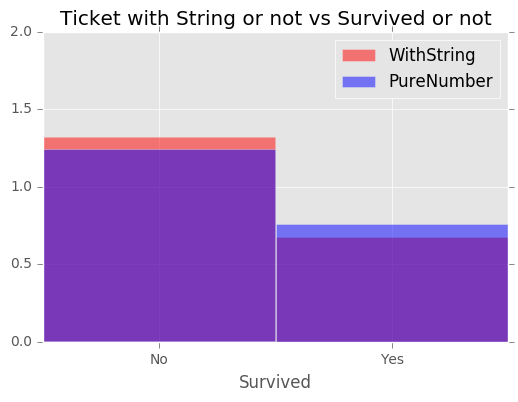

In [16]:
#Check what's special in feature Ticket
plt.hist(df_train.ix[pd.isnull(pd.to_numeric(df_train['Ticket'],errors = 'coerce')),'Survived'],bins = 2,normed = True, alpha = 0.5, color = 'r',label = 'WithString')
plt.hist(df_train.ix[~pd.isnull(pd.to_numeric(df_train['Ticket'],errors = 'coerce')),'Survived'],bins = 2,normed = True, alpha = 0.5, color = 'b',label = 'PureNumber')
plt.title('Ticket with String or not vs Survived or not')
plt.legend()
plt.xlabel('Survived')
plt.xticks([0.25,0.75],['No','Yes'])
plt.ylim([0,2.0])
plt.show()

In [17]:
#drop ticket column
df_train = df_train.drop(['Ticket'],axis=1)
df_test = df_test.drop(['Ticket'],axis=1)
df_pred = df_pred.drop(['Ticket'],axis=1)

Extracting title from name might be helpful.

In [18]:
Name_Temp_train = df_train['Name'].str.split(', ',expand=True).iloc[:,1].str.split('.',expand=True).iloc[:,0]
Name_Temp_test = df_test['Name'].str.split(', ',expand=True).iloc[:,1].str.split('.',expand=True).iloc[:,0]
Name_Temp_pred = df_pred['Name'].str.split(', ',expand=True).iloc[:,1].str.split('.',expand=True).iloc[:,0]
emp_train = {}
emp_test = {}
for name_train in Name_Temp_train:
    if name_train in emp_train.keys():
        emp_train[name_train] += 1
    else:
        emp_train[name_train] = 1
for name_test in Name_Temp_test:
    if name_test in emp_test.keys():
        emp_test[name_test] += 1
    else:
        emp_test[name_test] = 1
print "Prefix frequency among training set: ",emp_train
print "Prefix frequency among testing set: ",emp_test

Prefix frequency among training set:  {'Sir': 1, 'Major': 1, 'the Countess': 1, 'Don': 1, 'Mlle': 1, 'Capt': 1, 'Dr': 4, 'Rev': 6, 'Mrs': 81, 'Jonkheer': 1, 'Master': 27, 'Ms': 1, 'Mr': 360, 'Mme': 1, 'Miss': 134, 'Col': 2}
Prefix frequency among testing set:  {'Major': 1, 'Mlle': 1, 'Dr': 3, 'Lady': 1, 'Mrs': 44, 'Master': 13, 'Mr': 157, 'Miss': 48}


In [19]:
Name_Temp_train[Name_Temp_train == 'Mlle'] = 'Miss'
Name_Temp_train[Name_Temp_train == 'Ms'] = 'Miss'
Name_Temp_train[Name_Temp_train == 'Mme'] = 'Mrs'
Name_Temp_test[Name_Temp_test == 'Mlle'] = 'Miss'
Name_Temp_test[Name_Temp_test == 'Ms'] = 'Miss'
Name_Temp_test[Name_Temp_test == 'Mme'] = 'Mrs'
Name_Temp_pred[Name_Temp_pred == 'Mlle'] = 'Miss'
Name_Temp_pred[Name_Temp_pred == 'Ms'] = 'Miss'
Name_Temp_pred[Name_Temp_pred == 'Mme'] = 'Mrs'
regular = ['Miss','Mrs','Mr']
ind_train = []
ind_test = []
ind_pred = []
for i in Name_Temp_train: 
    ind_train.append(i not in regular)
for i in Name_Temp_test: 
    ind_test.append(i not in regular)
for i in Name_Temp_pred: 
    ind_pred.append(i not in regular)
Name_Temp_train[ind_train] = 'Rare'
Name_Temp_test[ind_test] = 'Rare'
Name_Temp_pred[ind_pred] = 'Rare'
df_train.loc[:,'Name'] = Name_Temp_train
df_test.loc[:,'Name'] = Name_Temp_test
df_pred.loc[:,'Name'] = Name_Temp_pred

In [20]:
#Convert Name into numbers('Miss':0, 'Mrs':1, 'Mr':2, 'Rare':3)
df_train.loc[:,'Name'] = df_train.Name.map({'Miss':0, 'Mrs':1, 'Mr':2, 'Rare':3})
df_test.loc[:,'Name'] = df_test.Name.map({'Miss':0, 'Mrs':1, 'Mr':2, 'Rare':3})
df_pred.loc[:,'Name'] = df_pred.Name.map({'Miss':0, 'Mrs':1, 'Mr':2, 'Rare':3})

In [21]:
#Convert Gender as number (female=1, male=0)
df_train.loc[:,'Sex'] = df_train.Sex.map({'female':1,'male':0})
df_test.loc[:,'Sex'] = df_test.Sex.map({'female':1,'male':0})
df_pred.loc[:,'Sex'] = df_pred.Sex.map({'female':1,'male':0})

In [22]:
df_pred.loc[pd.isnull(df_pred['Fare']),['Fare']] = df_train['Fare'].median()

Thirdly, let's check the relation between variables visually!

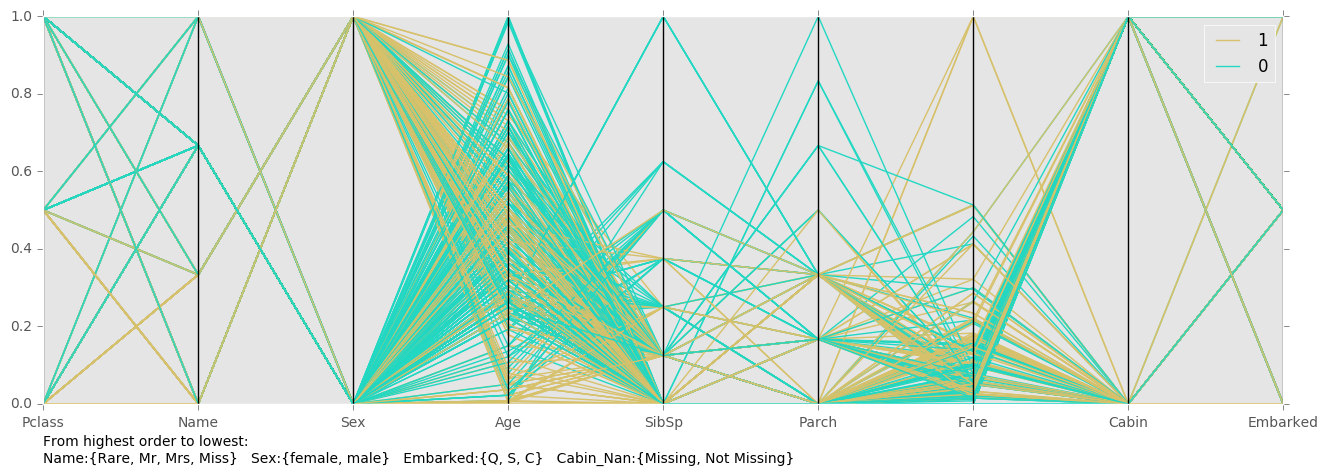

In [23]:
#Visualize in Parallel Coordinates
from pandas.tools.plotting import parallel_coordinates
from sklearn.preprocessing import MinMaxScaler
plt.figure(figsize=(16,5))
T = MinMaxScaler().fit_transform(df_train)
T = pd.DataFrame(T,columns=df_train.columns)
T.Survived = T.Survived.astype(int)
parallel_coordinates(T,'Survived')
plt.text(0,-0.15,'From highest order to lowest: \nName:{Rare, Mr, Mrs, Miss}   Sex:{female, male}   Embarked:{Q, S, C}   Cabin_Nan:{Missing, Not Missing}')
plt.show()

+ Most male in 1st class were not survived.
+ More than half of male survivors were teenagers, while no significant pattern of age among female survivors.
+ The more # of siblings, spouses, parents and children on board, the less likely he/she would decide to survive alone.

### Little preprocessing before modeling

In [24]:
#One-Hot encode
df_train = pd.get_dummies(df_train, columns = ['Embarked','Name','Sex','Cabin','Pclass'])
df_test = pd.get_dummies(df_test, columns = ['Embarked','Name','Sex','Cabin','Pclass'])
df_pred = pd.get_dummies(df_pred, columns = ['Embarked','Name','Sex','Cabin','Pclass'])

In [25]:
y_train = df_train['Survived']
y_test = df_test['Survived']
df_train = df_train.drop('Survived',axis=1)
df_test = df_test.drop('Survived',axis=1)
X_train = df_train
X_test = df_test
X_pred = df_pred.drop('PassengerId',axis=1)

In [26]:
#scaling data
Scaler = MinMaxScaler()
X_train.loc[:,['Age','SibSp','Parch','Fare']] = Scaler.fit_transform(X_train.loc[:,['Age','SibSp','Parch','Fare']].copy())
X_test.loc[:,['Age','SibSp','Parch','Fare']] = Scaler.transform(X_test.loc[:,['Age','SibSp','Parch','Fare']].copy())
X_pred.loc[:,['Age','SibSp','Parch','Fare']] = Scaler.transform(X_pred.loc[:,['Age','SibSp','Parch','Fare']].copy())

### Try some different models

In this part, I will start from Logistic Regression, SVM and Decision Tree to Random Forest, Adaboost and enhanced Adaboost.

Since data is not too complex, it is reasonable to try some simple model, like Logistic Regression, at first. Then SVM and Decisition Tree could be implemented if they bring improvement on predictive power. However, I tried Random Forest and Adaboost as well. 

Random Forest could be a good way to eliminate variance without increasing bias on prediction. And Adaboost has been proved to be more aggresive in fitting data than bagging algorithms, like Random Forest. 

Overfitting in Adaboost is also somehow an issue in practice. To avoid overfitting is telling algorithm not to fit on noise data. So I construct a reduced set, where noise data are removed, to enhance Adaboost. To see more details in this [paper](http://groups.inf.ed.ac.uk/calvin/hp_avezhnev/Pubs/AvoidingBoostingOverfitting.pdf).

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
#Validation Curve
def plt_vc(estimator,title, X, y, param_name, param_range, logspace = True):
    plt.figure()
    plt.title(title)
    plt.xlabel("Parameter")
    plt.ylabel("Score")
    plt.xlim()
    train_score, validation_score = validation_curve(estimator, X, y, param_name, param_range, cv=10, n_jobs=2)
    train_scores_mean = np.mean(train_score, axis=1)
    train_scores_std = np.std(train_score, axis=1)
    validation_scores_mean = np.mean(validation_score, axis=1)
    validation_scores_std = np.std(validation_score, axis=1)
    plt.grid()
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(param_range, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(param_range, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(param_range, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    if logspace:
        plt.xscale('log',basex = 2)
    if not logspace:
        plt.xlim(min(param_range), max(param_range))
    plt.legend(loc="best")
    plt.show()    

Fit Logistic Regression Model

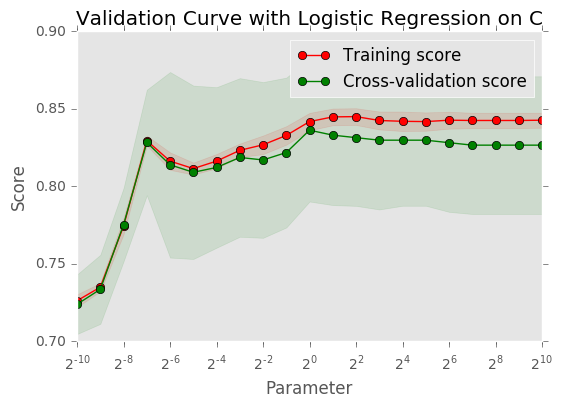

In [28]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state = 10)
plt_vc(model, 'Validation Curve with Logistic Regression on C', X_train, y_train, 'C', np.logspace(-10, 10, 21, base = 2.0))

In [29]:
#Fine grid search for C
parameters = {'C':np.logspace(-2, 2, 21, base = 2.0)}
clf_logreg = GridSearchCV(model, parameters)

Fit Decision Tree

In [30]:
from sklearn.model_selection import StratifiedKFold
def tuningDT(title, X, y, para, param_range, random_state = None, logspace = True, prune = False):
    parameters = {'min_node_size':5,
                  'alpha':0,
                  'threshold':0,
                  'response': y.name,
                  'metric_kind':'Gini',
                  'max_node_depth': 6}
    data_type_dict = {}
    for cname in X.columns.values:
        if np.dtype(getattr(X, cname)).type == np.float64:
            data_type_dict[cname] = 'continuous'
        else:
            data_type_dict[cname] = 'nominal'
    data_type_dict['Survived'] = 'nominal'
    model = ti.ClassificationTree()
    kf = StratifiedKFold(n_splits=10, random_state = random_state)
    train_score = []
    validation_score = []
    ind_train = X.index.values
    for p in param_range:
        parameters[para] = p
        t_score = 0
        v_score = 0
        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X.loc[ind_train[train_index],:], X.loc[ind_train[test_index],:]
            y_train, y_test = y[ind_train[train_index]], y[ind_train[test_index]]
            data_train = pd.merge(X_train,y_train.to_frame(name=y_train.name),left_index=True,right_index=True)
            data_test  = pd.merge(X_test,y_test.to_frame(name=y_test.name),left_index=True,right_index=True)
            model.train(data_train,data_type_dict,parameters, prune)
            t_score += (1 - model.error())
            v_score += (1 - model.test(data_test))
        t_score /= 10.0
        v_score /= 10.0
        train_score.append(t_score)
        validation_score.append(v_score)
    plt.figure()
    plt.title(title)
    plt.xlabel("Parameter")
    plt.ylabel("Score")
    plt.ylim(min(train_score+validation_score)*0.9,max(train_score+validation_score)*1.1)
    plt.grid()
    plt.plot(param_range, train_score, 'o-', color="r",
             label="Training score")
    plt.plot(param_range, validation_score, 'o-', color="g",
             label="Cross-validation score")
    if logspace:
        plt.xscale('log',basex = 2)
    if not logspace:
        plt.xlim(min(param_range), max(param_range))
    plt.legend(loc="best")
    plt.show()    

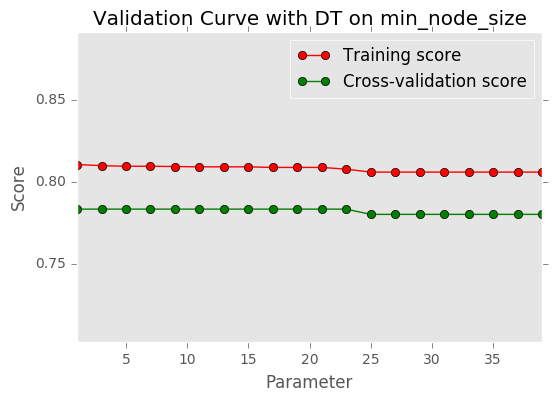

In [31]:
tuningDT('Validation Curve with DT on min_node_size', X_train, y_train,'min_node_size', np.linspace(1,39,20, dtype='int'), random_state = 10, logspace = False)

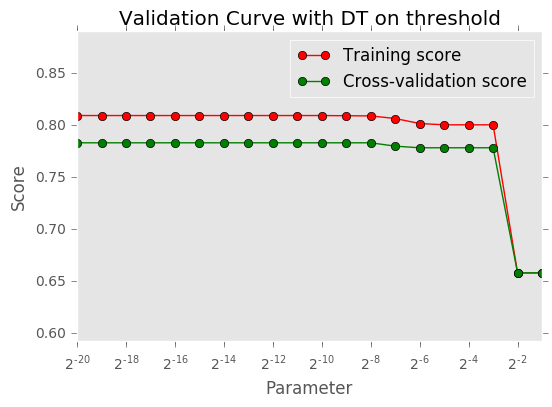

In [32]:
tuningDT('Validation Curve with DT on threshold', X_train, y_train, 'threshold', np.logspace(-20, -1, 20, base = 2.0), random_state = 10 )

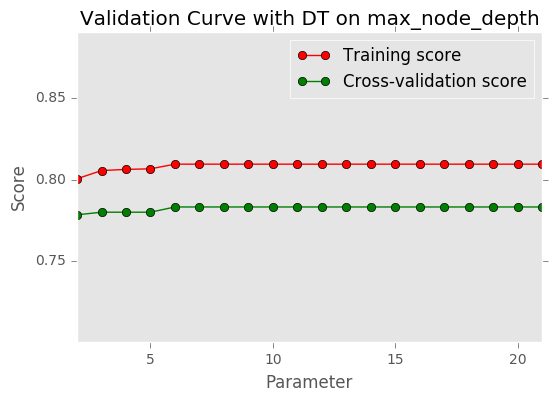

In [33]:
tuningDT('Validation Curve with DT on max_node_depth', X_train, y_train, 'max_node_depth', np.linspace(2,21,20, dtype='int'), random_state = 10 ,logspace = False)

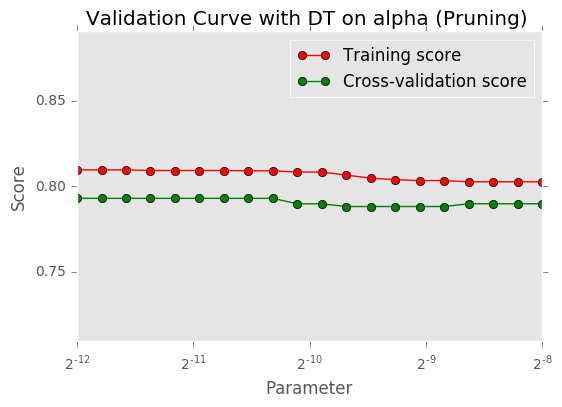

In [34]:
tuningDT('Validation Curve with DT on alpha (Pruning) ', X_train, y_train, 'alpha', np.logspace(-12, -8, 20, base = 2.0), random_state = 10 ,prune=True)

In [35]:
clf_dt = ti.ClassificationTree()

Fit Random Forest

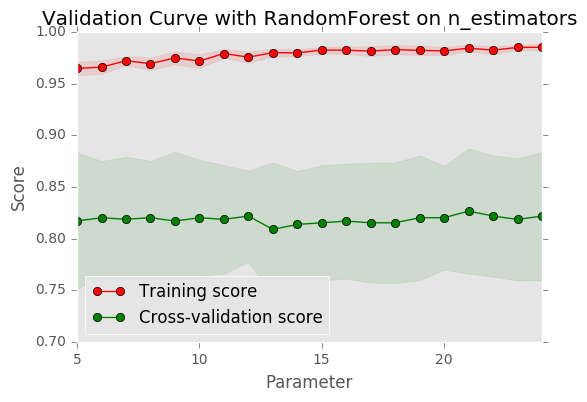

In [36]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 10)
plt_vc(model, 'Validation Curve with RandomForest on n_estimators', X_train, y_train, 'n_estimators', np.linspace(5,24,20, dtype='int'), logspace=False)

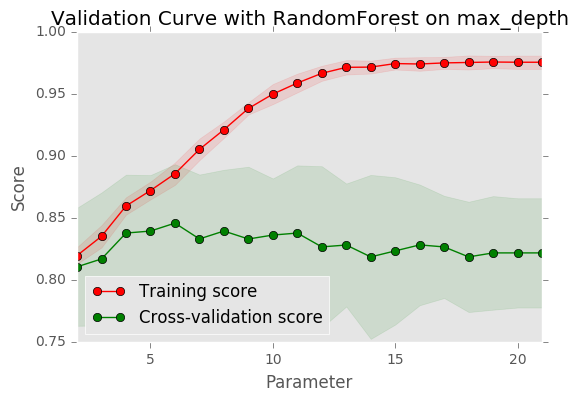

In [37]:
model = RandomForestClassifier(random_state = 10, n_estimators = 12)
plt_vc(model, 'Validation Curve with RandomForest on max_depth', X_train, y_train, 'max_depth', np.linspace(2,21,20, dtype='int'),logspace=False)

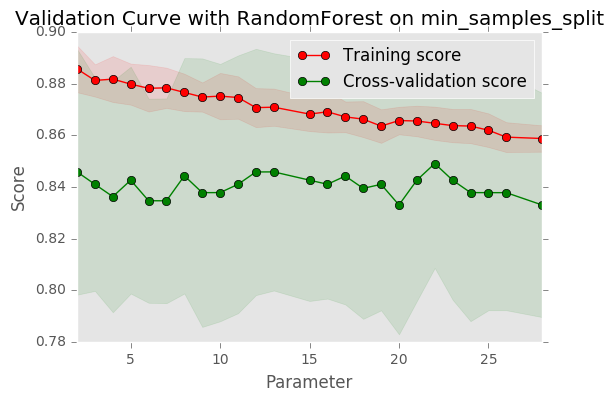

In [38]:
model = RandomForestClassifier(random_state = 10, n_estimators = 12, max_depth =6)
plt_vc(model, 'Validation Curve with RandomForest on min_samples_split', X_train, y_train, 'min_samples_split', np.linspace(2,28,25, dtype='int'),logspace=False)

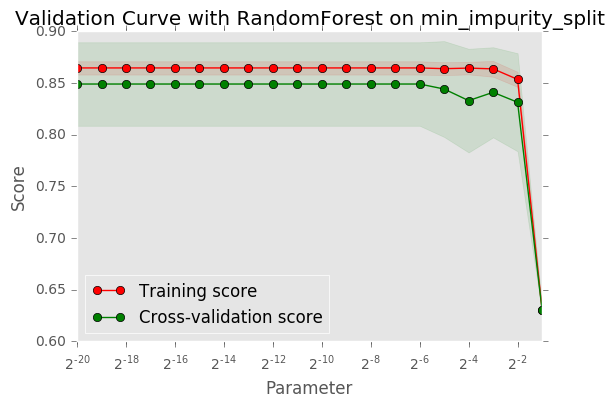

In [39]:
model = RandomForestClassifier(random_state = 10, n_estimators = 12, max_depth = 6, min_samples_split = 22)
plt_vc(model, 'Validation Curve with RandomForest on min_impurity_split', X_train, y_train, 'min_impurity_split', np.logspace(-20,-1,20, base=2.0))

In [40]:
clf_rf = RandomForestClassifier(random_state = 10, n_estimators = 12, max_depth = 6, min_samples_split = 22)

Fit SVC

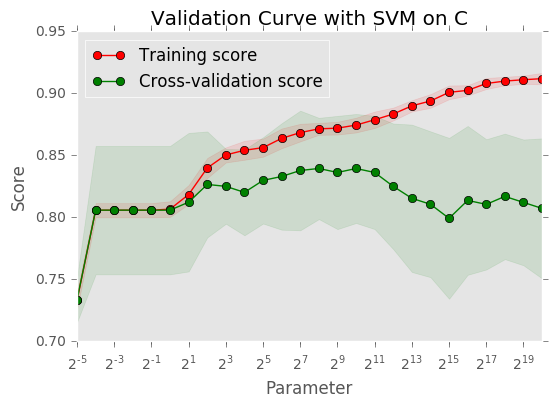

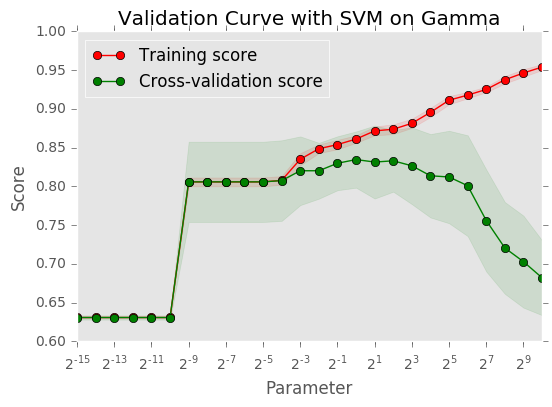

In [41]:
#Coarse parameter search
from sklearn.svm import SVC
model = SVC(random_state=10)
plt_vc(model, 'Validation Curve with SVM on C', X_train, y_train, 'C', np.logspace(-5, 20, 26, base = 2.0))
plt_vc(model, 'Validation Curve with SVM on Gamma', X_train, y_train, 'gamma', np.logspace(-15, 10, 26, base = 2.0))

In [42]:
#Fine grid search for C and Gamma
parameters = {'C':np.logspace(1, 11, 11, base = 2.0),'gamma':np.logspace(-1, 3, 11, base = 2.0)}
clf_svm = GridSearchCV(model, parameters)

Fit Adaboost

Fit Adaboost on RBF-SVM

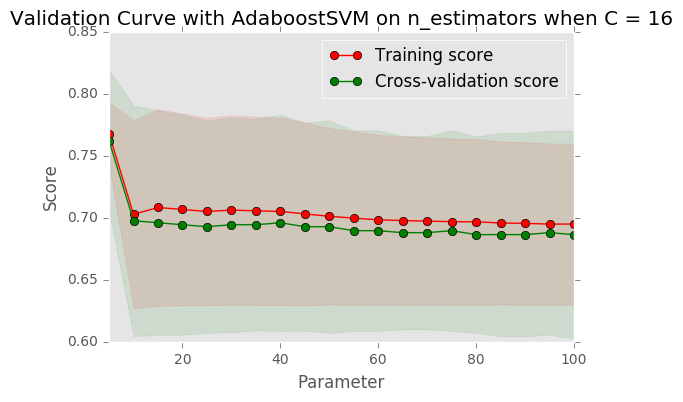

In [43]:
from sklearn.ensemble import AdaBoostClassifier
clf_AdaSVM = AdaBoostClassifier(SVC(C = 16,probability = True, random_state=10), random_state = 10)
plt_vc(clf_AdaSVM, 'Validation Curve with AdaboostSVM on n_estimators when C = 16', X_train, y_train, 'n_estimators', np.linspace(5, 100, 20, dtype='int'), logspace=False)

Fit Adaboost Decision Tree

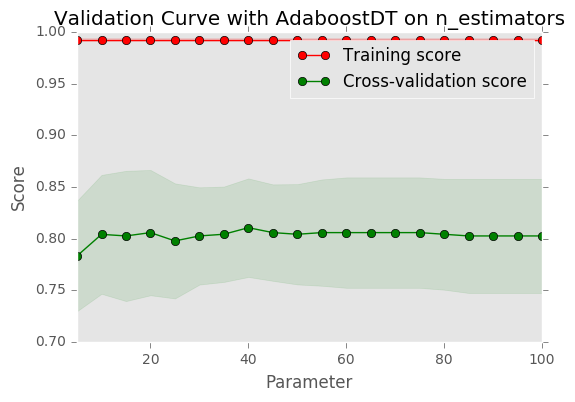

In [44]:
from sklearn.tree import DecisionTreeClassifier
clf_AdaDT = AdaBoostClassifier(DecisionTreeClassifier(), random_state = 10)
plt_vc(clf_AdaDT, 'Validation Curve with AdaboostDT on n_estimators', X_train, y_train, 'n_estimators', np.linspace(5, 100, 20, dtype='int'), logspace=False)

In [45]:
import scipy.optimize as op
class ReducedSet:
    
    def plattll(self, theta, prob, y):
        A, B = theta
        p = 1.0 / (1 + np.exp(A * prob + B))
        return - np.sum((y * np.log(p) + (1 - y) * np.log(1 - p)))
    
    def platt(self, prob, y):
        ll = lambda *args: self.plattll(*args)
        result = op.minimize(ll, [1,1], args = (prob, y))
        A, B = result["x"]
        return A, B
    
    def getset(self, AdaBoost, X, y, K, random_state = None):
        p = np.zeros(X.shape[0])
        
        for i in range(K):
            X_set1, X_set2, y_set1, y_set2 = train_test_split(X, y, test_size = 0.7, random_state = random_state)
            AdaBoost.fit(X_set1, y_set1)
            prob = AdaBoost.predict_proba(X_set2)[:,1]
            A, B = self.platt(prob, y_set2)
            prob_whole = AdaBoost.predict_proba(X)[:,1]
            p += 1.0 / (1 + np.exp(A * prob_whole + B))
        
        p /= K
        
        ind = X.index.values
        ind_select = []
        
        for j in range(X.shape[0]):
            if y.loc[ind[j]] == 1:
                if p[j] > 0.5:
                    ind_select.append(ind[j])
            else:
                if p[j] < 0.5:
                    ind_select.append(ind[j]) 
        
        return(X.loc[ind_select,:], y.loc[ind_select])
    

In [46]:
reduceset = ReducedSet()

In [47]:
#Reduced set for DT
clf_AdaSVM_Reduced = AdaBoostClassifier(SVC(C = 25,probability = True, random_state=10), random_state = 10)
clf_AdaDT_Reduced = AdaBoostClassifier(DecisionTreeClassifier(),random_state = 10)

### Great! It's time to evaluate models by cross-validation score

In [48]:
from sklearn.model_selection import cross_val_score
cv = StratifiedKFold(n_splits=10, random_state=10) 
cv_score = {}

In [49]:
cv_score['DT'] = 0
cv_score['ReducedAdaSVM'] = 0
cv_score['ReducedAdaDT'] = 0

parameters = {    'min_node_size':5,
                  'alpha': 2**-10.2,
                  'threshold':0,
                  'response': y_train.name,
                  'metric_kind':'Gini',
                  'max_node_depth': 5}
data_type_dict = {}
for cname in X_train.columns.values:
    if np.dtype(getattr(X_train, cname)).type == np.float64:
        data_type_dict[cname] = 'continuous'
    else:
        data_type_dict[cname] = 'nominal'
data_type_dict['Survived'] = 'nominal'
ind_train = X_train.index.values

for train_index, test_index in cv.split(X_train, y_train):
    X_train_cv, X_test_cv = X_train.loc[ind_train[train_index],:], X_train.loc[ind_train[test_index],:]
    y_train_cv, y_test_cv = y_train[ind_train[train_index]], y_train[ind_train[test_index]]
    X_reduced_DT, y_reduced_DT = reduceset.getset(clf_AdaDT, X_train_cv, y_train_cv, 50)
    X_reduced_SVM, y_reduced_SVM = reduceset.getset(clf_AdaSVM, X_train_cv, y_train_cv, 50)
    data_train = pd.merge(X_train_cv,y_train_cv.to_frame(name=y_train_cv.name),left_index=True,right_index=True)
    data_test  = pd.merge(X_test_cv,y_test_cv.to_frame(name=y_test_cv.name),left_index=True,right_index=True)
    clf_dt.train(data_train, data_type_dict,parameters ,prune=True)
    clf_AdaDT_Reduced.fit(X_reduced_DT, y_reduced_DT)
    clf_AdaSVM_Reduced.fit(X_reduced_SVM, y_reduced_SVM)
    cv_score['DT'] += (1 - clf_dt.test(data_test))
    cv_score['ReducedAdaDT'] += clf_AdaDT_Reduced.score(X_test_cv, y_test_cv)
    cv_score['ReducedAdaSVM'] += clf_AdaSVM_Reduced.score(X_test_cv, y_test_cv)
cv_score['DT'] /= 10
cv_score['ReducedAdaDT'] /= 10
cv_score['ReducedAdaSVM'] /= 10
cv_score['LogReg'] = np.mean(cross_val_score(clf_logreg, X_train, y_train, cv=cv))
cv_score['rf'] = np.mean(cross_val_score(clf_rf, X_train, y_train, cv=cv))
cv_score['svm'] = np.mean(cross_val_score(clf_svm, X_train, y_train, cv=cv))
cv_score['AdaDT'] = np.mean(cross_val_score(clf_AdaDT, X_train, y_train, cv=cv))
cv_score['AdaSVM'] = np.mean(cross_val_score(clf_AdaSVM, X_train, y_train, cv=cv))

//anaconda/lib/python2.7/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


In [50]:
print 'Summary'
for key in cv_score.keys():
    print 'CV Score of '+ key + ": ", cv_score[key]

Summary
CV Score of svm:  0.83783922171
CV Score of ReducedAdaDT:  0.841065028162
CV Score of LogReg:  0.828213005632
CV Score of rf:  0.849052739375
CV Score of ReducedAdaSVM:  0.741474654378
CV Score of AdaDT:  0.804198668715
CV Score of DT:  0.789708141321
CV Score of AdaSVM:  0.692933947773


### Comparably, SVM, Random Forest and Enhanced Adaboost on Decision Tree owns the best predictive power. 
No obvious overfitting among these three models when I get score from test set

In [54]:
clf_rf.fit(X_train, y_train)
X_reduced, y_reduced = reduceset.getset(clf_AdaDT, X_train, y_train, 50)
clf_AdaDT.fit(X_reduced, y_reduced)
clf_svm.fit(X_train, y_train)
print 'Test Score of Random Forest: ', clf_rf.score(X_test, y_test)
print 'Test Score of SVM: ', clf_svm.score(X_test, y_test)
print 'Test Score of Adaboost Decision Tree on Reduced Set: ', clf_AdaDT.score(X_test, y_test)

 Test Score of Random Forest:  0.776119402985
Test Score of SVM:  0.783582089552
Test Score of Adaboost Decision Tree on Reduced Set:  0.776119402985


_Note: My recent best score is 0.8094 from Enhanced Adaboost on Decision Tree_